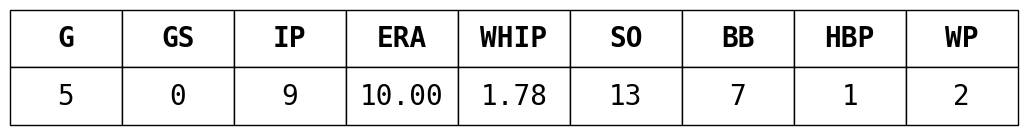

In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import warnings
from matplotlib.patches import Polygon
import seaborn as sns
import numpy as np
import matplotlib.gridspec as gridspec
import math
import matplotlib.ticker as mtick
from matplotlib.ticker import MaxNLocator
from matplotlib.patches import Rectangle

mpl.rcParams['font.family'] = 'DejaVu Sans Mono'

def basic_stats_table(ax: plt.Axes):

    data = {
        "Tm": ["Falmouth"],
        "Year": [2025],
        "G": [5],
        "GS": [0],
        "IP": [9],
        "ERA": [10.00],
        "WHIP": [1.78],
        "SO": [13],
        "BB": [7],
        "HBP": [1],
        "WP": [2]
    }

    df = pd.DataFrame(data)

    df["ERA"] = df["ERA"].map("{:.2f}".format)
    df["WHIP"] = df["WHIP"].map("{:.2f}".format)
    int_cols = ["SO", "BB", "HBP", "WP", "G", "GS"]
    for col in int_cols:
        df[col] = df[col].astype(int)

    display_df = df.drop(columns=["Year", "Tm"])

    table = ax.table(
        cellText=display_df.values,
        colLabels=display_df.columns,
        loc="center",
        cellLoc="center",
        colLoc="center",
        bbox=[0, 0, 1, 1]
    )

    for (row, col), cell in table.get_celld().items():
        if row == 0:
            cell.set_text_props(weight="bold")

    table.auto_set_font_size(False)
    table.set_fontsize(20)
    table.scale(1.5, 1.5)
    ax.axis("off")


fig, ax = plt.subplots(figsize=(13, 1.5))
basic_stats_table(ax=ax)
plt.show()

In [2]:
player_name_input = input("Enter a player name (Last, First): ").strip()

Enter a player name (Last, First):  Porco, Robby


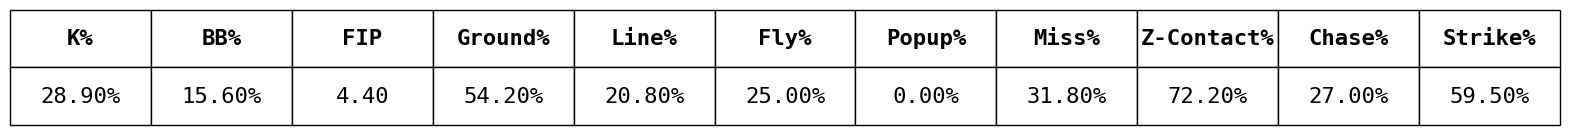

In [3]:
normalized_name = player_name_input.lower().replace(",", "").replace(" ", "")

def falmouth_stats_table(ax: plt.Axes, player_filter: str):
    warnings.filterwarnings("ignore", category=FutureWarning)

    df = pd.read_excel(r"C:\Users\brend\OneDrive - Stonehill College\Falmouth - Main Dashboard.xlsx")

    df["playerFullName"] = df["playerFullName"].apply(lambda x: f"{x.split()[-1]}, {' '.join(x.split()[:-1])}".strip())
    df["normalizedName"] = df["playerFullName"].str.lower().replace(",", "", regex=True).str.replace(" ", "", regex=False)

    if player_filter:
        df = df[df["normalizedName"] == player_filter]

    display_df = df[[
        "K%", "BB%", "FIP", "Ground%", "Line%", "Fly%", "Popup%", 
        "Miss%", "InZoneWhiff%", "Chase%", "Strike%"
    ]].copy()

    for col in display_df.columns:
        display_df[col] = (
            display_df[col]
            .astype(str)
            .str.replace("%", "", regex=False)
            .str.strip()
            .astype(float)
        )
        
    if "InZoneWhiff%" in display_df.columns:
        display_df["Z-Contact%"] = 1 - display_df["InZoneWhiff%"]
        display_df = display_df.drop(columns=["InZoneWhiff%"])
    
        cols = list(display_df.columns)
        miss_idx = cols.index("Miss%")
        cols.insert(miss_idx + 1, cols.pop(cols.index("Z-Contact%")))
        display_df = display_df[cols]
    
    for col in display_df.columns:
        if col == "FIP":
            display_df[col] = display_df[col].map("{:.2f}".format)
        else:
            display_df[col] = (display_df[col] * 100).map("{:.2f}%".format)

    table = ax.table(
        cellText=display_df.values,
        colLabels=display_df.columns,
        loc="center",
        cellLoc="center",
        colLoc="center",
        bbox=[0, 0, 1, 1]
    )
    table.auto_set_font_size(False)
    table.set_fontsize(16)
    table.scale(1.3, 1.2)

    for (row, col), cell in table.get_celld().items():
        if row == 0:
            cell.set_text_props(weight="bold")

    ax.axis("off")

fig, ax = plt.subplots(figsize=(20, 1.5))
falmouth_stats_table(ax=ax, player_filter=normalized_name)
plt.show()

In [8]:
excel_file = r"C:\Users\brend\OneDrive - Stonehill College\All Cape League Trackman.xlsx"
df = pd.read_excel(excel_file)

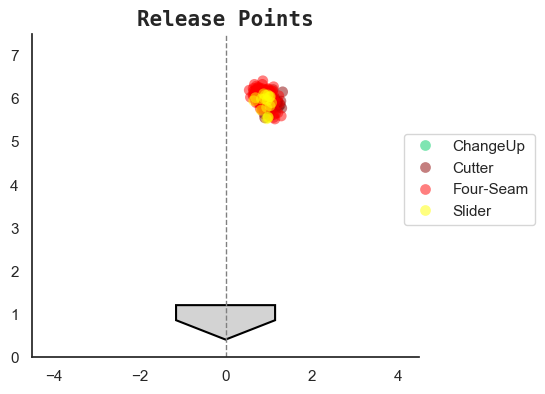

In [9]:
def standardize_pitch_types(df):
    pitch_map = {
        "FourSeamFastBall": "Four-Seam",
        "Four-Seam": "Four-Seam",
        "Fastball": "Four-Seam",
        "2-Seam": "Two-Seam",
        "TwoSeamFastBall": "Two-Seam",
        "Sinker": "Sinker",
        "ChangeUp": "ChangeUp",
        "Slider": "Slider",
        "Curveball": "Curveball",
        "Cutter": "Cutter",
        "Splitter": "Splitter"
    }
    df["TaggedPitchType"] = df["TaggedPitchType"].map(lambda x: pitch_map.get(x, x))
    return df

df = standardize_pitch_types(df)

dict_color = {
    "Four-Seam": "#FF0000",
    "Two-Seam": "#FF6666",
    "Sinker": "#FFA500",
    "ChangeUp": "#00CC66",
    "Slider": "#FFFF00",
    "Curveball": "#ADD8E6",
    "Cutter": "#8B0000",
    "Splitter": "#008080"
}

player_df = df[
    (df["Pitcher"].str.strip() == player_name_input.strip()) & 
    df["RelHeight"].notna() & 
    df["RelSide"].notna() & 
    df["TaggedPitchType"].notna()
].copy()

if not player_df["PitcherThrows"].isna().all():
    if player_df["PitcherThrows"].iloc[0] == "L":
        player_df["RelSide"] *= -1

if player_df.empty:
    print(f"No data found for player: {player_name_input}")

else:
    unique_pitches = player_df["TaggedPitchType"].unique()
    color_map = {pitch: dict_color.get(pitch, "black") for pitch in unique_pitches}

    plt.figure(figsize=(5, 7))
    sns.set(style="white")

    sns.scatterplot(
        data=player_df,
        x="RelSide",
        y="RelHeight",
        hue="TaggedPitchType",
        palette=color_map,
        s=60,
        edgecolor="none",
        alpha=0.5
    )

    plt.axvline(0, linestyle="--", color="gray", linewidth=1)
    plt.xlabel("")
    plt.ylabel("")
    plt.xlim(-4.5, 4.5)
    plt.ylim(0, 7.5)
    plt.gca().set_aspect('equal', adjustable='box')
    plt.title("Release Points", font="DejaVu Sans Mono", fontsize=15, weight="bold")
    plt.legend(
        title="",
        loc="center left",
        bbox_to_anchor=(.96, 0.55),
        borderaxespad=0.
    )
    sns.despine()
    
    plate_y = 1.2
    half_width = 1.15
    inner_y_offset = 0.35
    point_depth = 0.8

    plate = Polygon(
        [
            [-half_width, plate_y],
            [ half_width, plate_y],
            [ half_width, plate_y - inner_y_offset],
            [0.00, plate_y - point_depth],
            [-half_width, plate_y - inner_y_offset]  
        ],
        closed=True,
        facecolor='lightgray',
        edgecolor='black',
        linewidth=1.5,
        zorder=1
    )
    plt.gca().add_patch(plate)

    plt.show()

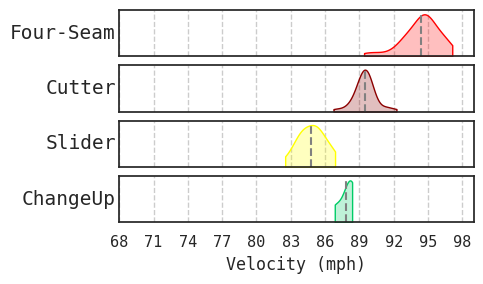

In [10]:
mpl.rcParams['font.family'] = 'DejaVu Sans Mono'

df = standardize_pitch_types(df)

df = df[df["Pitcher"] == player_name_input]

df_filtered = df[df["RelSpeed"].notna()]
df_filtered = df_filtered[df_filtered["RelSpeed"] >= 40]

pitch_counts = df_filtered["TaggedPitchType"].value_counts()
valid_pitches = pitch_counts[pitch_counts >= 2].index
df_filtered = df_filtered[df_filtered["TaggedPitchType"].isin(valid_pitches)]

def velocity_dist(df: pd.DataFrame,
                  ax: plt.Axes,
                  gs: gridspec,
                  gs_x: list,
                  gs_y: list,
                  fig: plt.Figure,
                  custom_floor: int = None,
                  custom_ceiling: int = None):

    sorted_value_counts = df["TaggedPitchType"].value_counts().sort_values(ascending=False)
    items_in_order = sorted_value_counts.index.tolist()

    ax.axis("off")

    inner_grid_1 = gridspec.GridSpecFromSubplotSpec(len(items_in_order), 1, subplot_spec=gs[gs_x[0]:gs_x[-1], gs_y[0]:gs_y[-1]])
    ax_top = []

    for inner in inner_grid_1:
        ax_top.append(fig.add_subplot(inner))

    for ax_number, pitch_type in enumerate(items_in_order):
        pitch_data = df[df["TaggedPitchType"] == pitch_type]["RelSpeed"]

        if pitch_data.nunique() == 1:
            velocity = pitch_data.values[0]
            ax_top[ax_number].plot([velocity, velocity], [0, 1], linewidth=4,
                                   color=dict_color.get(pitch_type, "black"), zorder=20)
        else:
            sns.kdeplot(pitch_data, ax=ax_top[ax_number], fill=True,
                        clip=(pitch_data.min(), pitch_data.max()),
                        color=dict_color.get(pitch_type, "black"))
            ax_top[ax_number].set_ylabel("")
            ax_top[ax_number].set_xlabel("")

        avg_velocity = pitch_data.mean()
        ax_top[ax_number].plot([avg_velocity, avg_velocity],
                               [ax_top[ax_number].get_ylim()[0], ax_top[ax_number].get_ylim()[1]],
                               color="grey", linestyle="--")

        x_min = custom_floor if custom_floor is not None else math.floor(df["RelSpeed"].min() / 5) * 5 - 5
        x_max = custom_ceiling if custom_ceiling is not None else math.ceil(df["RelSpeed"].max() / 5) * 5

        ax_top[ax_number].set_xlim(x_min, x_max)
        ax_top[ax_number].set_xticks(np.arange(x_min, x_max, 3))
        ax_top[ax_number].set_yticks([])
        ax_top[ax_number].grid(axis="x", linestyle="--")
        ax_top[ax_number].text(-0.01, 0.5, pitch_type, transform=ax_top[ax_number].transAxes,
                               fontsize=14, va="center", ha="right")

        if ax_number < len(items_in_order) - 1:
            ax_top[ax_number].tick_params(axis="x", colors="none")

    ax_top[-1].set_xlabel("Velocity (mph)")

fig, ax = plt.subplots(figsize=(5, 3))
velocity_dist(df=df_filtered,
              ax=ax,
              gs=gridspec.GridSpec(1, 1),
              gs_x=[0, 1],
              gs_y=[0, 1],
              fig=fig,
              custom_floor=68,
              custom_ceiling=99)

plt.tight_layout()
plt.show()

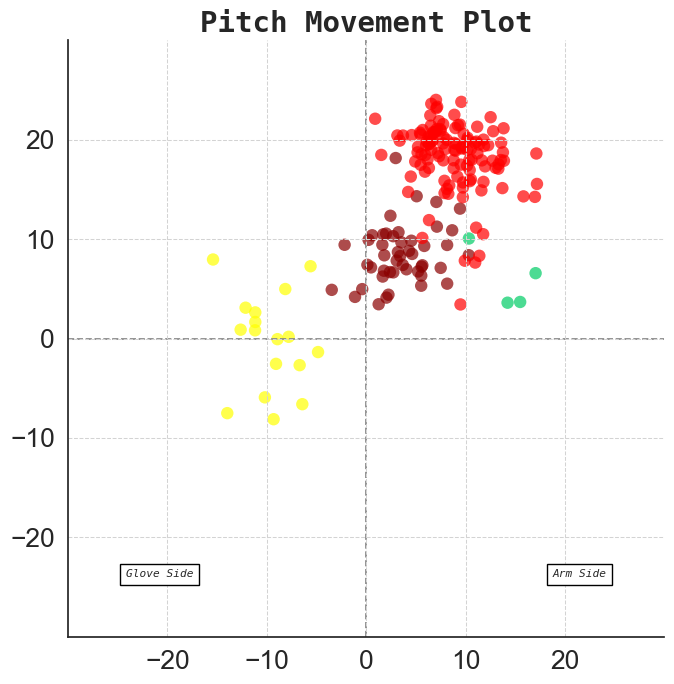

In [11]:
player_df = df[
    (df["Pitcher"].str.strip() == player_name_input) &
    df["TaggedPitchType"].notna() &
    df["BatterSide"].isin(["Right", "Left"])
].copy()

player_df = standardize_pitch_types(player_df)

pitch_types_used = player_df["TaggedPitchType"].unique()
color_map = {pitch: dict_color.get(pitch, "black") for pitch in pitch_types_used}

plt.figure(figsize=(7, 7))
sns.set(style="white")

sns.scatterplot(
    data=player_df,
    x="HorzBreak",
    y="InducedVertBreak",
    hue="TaggedPitchType",
    palette=color_map,
    s=80,
    edgecolor="none",
    alpha=0.7,
    legend=False
)

plt.axhline(0, color='gray', linestyle='--', linewidth=1.2)
plt.axvline(0, color='gray', linestyle='--', linewidth=1.2)

for tick in range(-20, 21, 10):
    plt.axhline(tick, color='#D3D3D3', linestyle='--', linewidth=0.75)
    plt.axvline(tick, color='#D3D3D3', linestyle='--', linewidth=0.75)

plt.xlim(-30, 30)
plt.ylim(-30, 30)
plt.xticks(range(-20, 21, 10), fontsize=19)
plt.yticks(range(-20, 21, 10), fontsize=19)
plt.xlabel("", fontsize=15)
plt.ylabel("", fontsize=15)
plt.gca().set_aspect('equal', adjustable='box')
plt.title("Pitch Movement Plot", font="DejaVu Sans Mono", fontsize=21, fontweight='bold')

PitcherThrows = player_df["PitcherThrows"].dropna().iloc[0] if not player_df["PitcherThrows"].dropna().empty else None

if PitcherThrows == "Right":
    plt.text(-24.2, -24.2, 'Glove Side', font="DejaVu Sans Mono", fontstyle='italic', ha='left', va='bottom',
             bbox=dict(facecolor='white', edgecolor='black'), fontsize=8)
    plt.text(24.2, -24.2, 'Arm Side', font="DejaVu Sans Mono", fontstyle='italic', ha='right', va='bottom',
             bbox=dict(facecolor='white', edgecolor='black'), fontsize=8)
elif PitcherThrows == "Left":
    plt.text(24.2, -24.2, 'Glove Side', font="DejaVu Sans Mono", fontstyle='italic', ha='left', va='bottom',
             bbox=dict(facecolor='white', edgecolor='black'), fontsize=8)
    plt.text(-24.2, -24.2, 'Arm Side', font="DejaVu Sans Mono", fontstyle='italic', ha='right', va='bottom',
             bbox=dict(facecolor='white', edgecolor='black'), fontsize=8)

sns.despine()
plt.tight_layout()
plt.show()

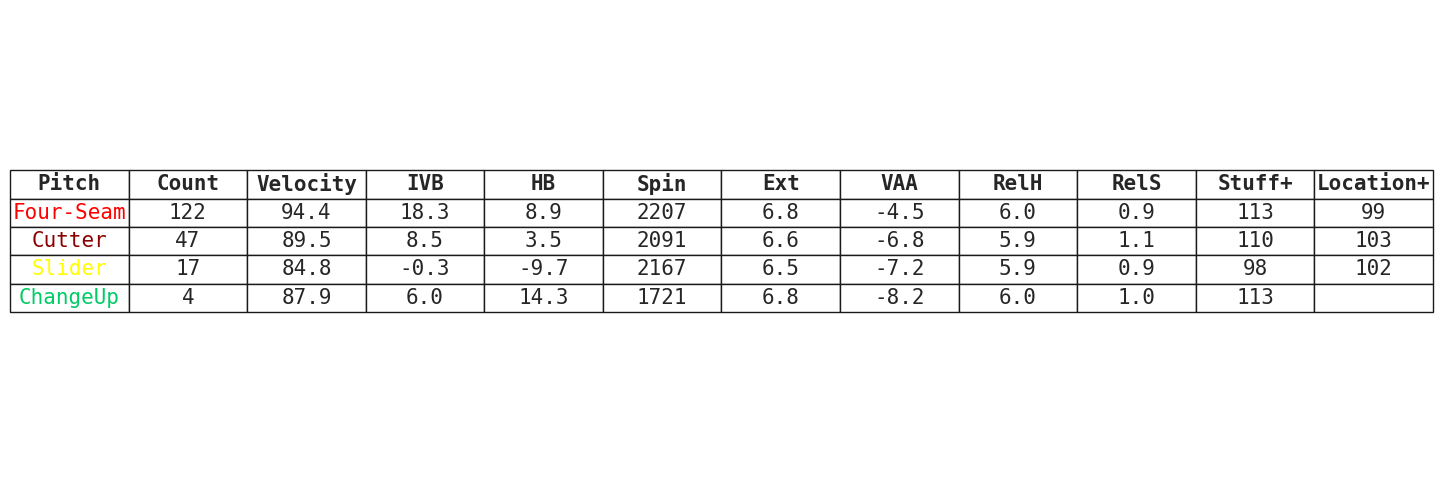

In [23]:
mpl.rcParams['font.family'] = 'DejaVu Sans Mono'

stuff_plus_values = {
    'Four-Seam': 113,
    'Cutter': 110,
    'Slider': 98,
    'ChangeUp': 113,
}

location_plus_values = {
    'Four-Seam': 99,
    'Cutter': 103,
    'Slider': 102,
    'ChangeUp': None,
}

df = standardize_pitch_types(df)

def create_statcast_table(df: pd.DataFrame, player_name_input: str) -> pd.DataFrame:
    player_df = df[df["Pitcher"].str.strip() == player_name_input.strip()].copy()
    player_df = player_df[player_df["TaggedPitchType"].notna()]

    player_df = standardize_pitch_types(player_df)

    summary = player_df.groupby("TaggedPitchType").agg(
        Count=("TaggedPitchType", "size"),
        Velocity=("RelSpeed", "mean"),
        IVB=("InducedVertBreak", "mean"),
        HB=("HorzBreak", "mean"),
        Spin=("SpinRate", "mean"),
        Ext=("Extension", "mean"),
        VAA=("VertApprAngle", "mean"),
        RelH=("RelHeight", "mean"),
        RelS=("RelSide", "mean"),
    ).reset_index()

    summary = summary[summary["TaggedPitchType"].str.lower() != "other"]
    summary = summary[summary["TaggedPitchType"].str.lower() != "undefined"]

    total_pitches = summary["Count"].sum()
    summary["Usage"] = 100 * summary["Count"] / total_pitches
    summary = summary.rename(columns={"TaggedPitchType": "Pitch"})

    summary["Stuff+"] = summary["Pitch"].map(stuff_plus_values)
    summary["Location+"] = summary["Pitch"].map(location_plus_values)

    return summary[[
        "Pitch", "Count", "Velocity", "IVB", "HB",
        "Spin", "Ext", "VAA", "RelH", "RelS", "Stuff+", "Location+"
    ]]

def generate_pitch_color_map(pitch_types):
    return {pitch: dict_color.get(pitch, "black") for pitch in pitch_types}

def statcast_table(ax: plt.Axes, df: pd.DataFrame, player_name_input: str, pitch_colors: dict):
    table_df = create_statcast_table(df, player_name_input)

    table_df = table_df.sort_values(by="Count", ascending=False).reset_index(drop=True)

    for col in ["Velocity", "IVB", "HB", "Ext", "VAA", "RelH", "RelS"]:
        table_df[col] = table_df[col].map("{:.1f}".format)
    table_df["Spin"] = table_df["Spin"].map("{:.0f}".format)
    table_df["Stuff+"] = table_df["Stuff+"].map("{:.0f}".format)
    table_df["Location+"] = table_df["Location+"].apply(lambda x: "{:.0f}".format(x) if pd.notnull(x) else "")

    table = ax.table(
        cellText=table_df.values,
        colLabels=table_df.columns,
        loc='center',
        cellLoc='center',
        colLoc='center'
    )

    for i, pitch in enumerate(table_df['Pitch']):
        color = pitch_colors.get(pitch, 'black')
        table[(i + 1, 0)].set_text_props(color=color)

    table.auto_set_font_size(False)
    table.set_fontsize(15)
    table.scale(1.02, 1.7)
    ax.axis('off')

    for (row, col), cell in table.get_celld().items():
        if row == 0:
            cell.set_text_props(weight="bold")

player_pitches = df[
    (df["Pitcher"].str.strip() == player_name_input.strip()) &
    df["TaggedPitchType"].notna()
]["TaggedPitchType"].unique()

pitch_color_map = generate_pitch_color_map(player_pitches)

fig, ax = plt.subplots(figsize=(18, 6))
statcast_table(ax, df, player_name_input, pitch_color_map)
plt.show()

Rows after filtering: 190
Unique Dates: 5
Pitch Types: ['ChangeUp' 'Cutter' 'Four-Seam' 'Slider']


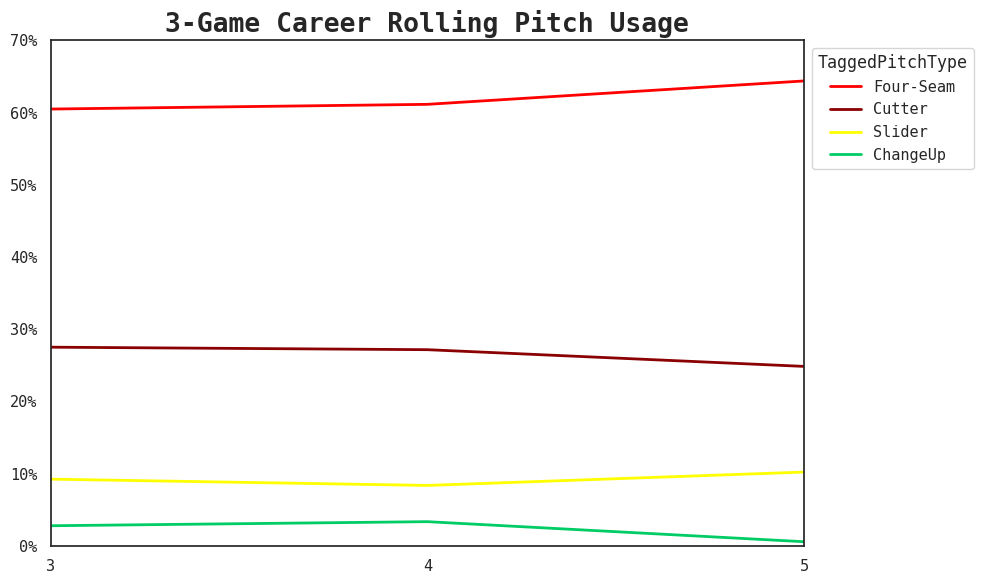

In [13]:
def rolling_pitch_usage(df: pd.DataFrame, ax: plt.Axes, dict_color: dict, window: int):

    df = df[df['RelSpeed'] >= 35]

    print("Rows after filtering:", len(df))
    print("Unique Dates:", df['Date'].nunique())
    print("Pitch Types:", df['TaggedPitchType'].unique())

    df['Date'] = pd.to_datetime(df['Date'])

    df_grouped = (
        df.groupby(['Date', 'TaggedPitchType'])['RelSpeed'].count() /
        df.groupby(['Date'])['RelSpeed'].count()
    ).reset_index(name='Pitch Usage')

    all_games = pd.Series(df_grouped['Date'].unique())
    all_pitch_types = pd.Series(df_grouped['TaggedPitchType'].unique())

    all_combinations = pd.MultiIndex.from_product(
        [all_games, all_pitch_types], names=['Date', 'TaggedPitchType']
    ).to_frame(index=False)

    df_complete = pd.merge(all_combinations, df_grouped, on=['Date', 'TaggedPitchType'], how='left')
    df_complete['Pitch Usage'] = df_complete['Pitch Usage'].fillna(0)

    df_complete = df_complete.sort_values(by='Date')
    df_complete['game_number'] = df_complete.groupby('Date').ngroup() + 1

    sorted_value_counts = df['TaggedPitchType'].value_counts().sort_values(ascending=False)
    items_in_order = sorted_value_counts.index.tolist()

    max_roll = []

    for pitch_type in items_in_order:
        pitch_data = df_complete[df_complete['TaggedPitchType'] == pitch_type]
        roll_values = pitch_data['Pitch Usage'].rolling(window).mean()

        sns.lineplot(
            x=pitch_data['game_number'],
            y=roll_values,
            label=pitch_type,
            ax=ax,
            linewidth=2,
            color=dict_color.get(pitch_type, 'black')
        )
        max_roll.append(roll_values.max())

    ax.set_xlim(window, df_complete['game_number'].max())
    max_valid = max([v for v in max_roll if not pd.isna(v)], default=0)
    ax.set_ylim(0, math.ceil(max_valid * 10) / 10)
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.set_title(f"{window}-Game Career Rolling Pitch Usage", fontweight='bold', fontsize=19)
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1, decimals=0))
    ax.legend(loc='upper left', bbox_to_anchor=(1, 1), title='TaggedPitchType')

fig, ax = plt.subplots(figsize=(10, 6))
rolling_pitch_usage(df, ax=ax, dict_color=dict_color, window=3)
plt.tight_layout()
plt.show()

In [14]:
df['Side'] = df['BatterSide'].map({'Right': 'RHH', 'Left': 'LHH'})
df = df[df['TaggedPitchType'].notna()]

total_by_hitter = df.groupby('Side').size()
usage_df = df.groupby(['TaggedPitchType', 'Side']).size().reset_index(name='count')
usage_df['total'] = usage_df['Side'].map(total_by_hitter)
usage_df['pitch_usage'] = (usage_df['count'] / usage_df['total']) * 100
usage_df['pitch_usage'] = usage_df['pitch_usage'].round(1).astype(str) + '%'
usage_df = usage_df.drop(columns=['count', 'total'])
usage_df = usage_df.rename(columns={'TaggedPitchType': 'Pitch Type', 'pitch_usage': 'Usage'})

swing_calls = ['StrikeSwinging', 'FoulBallNotFieldable', 'FoulBallFieldable', 'InPlay']
whiff_calls = ['StrikeSwinging']

df['is_swing'] = df['PitchCall'].isin(swing_calls)
df['is_whiff'] = df['PitchCall'].isin(whiff_calls)

whiff_stats = df.groupby(['TaggedPitchType', 'Side']).agg(
    total_swings=('is_swing', 'sum'),
    whiffs=('is_whiff', 'sum')
).reset_index()

whiff_stats['whiff_rate'] = (whiff_stats['whiffs'] / whiff_stats['total_swings'].replace(0, np.nan)) * 100
whiff_stats['whiff_rate'] = whiff_stats['whiff_rate'].fillna(0).round(1).astype(str) + '%'

whiff_stats = whiff_stats.drop(columns=['total_swings', 'whiffs'])
whiff_stats = whiff_stats.rename(columns={'TaggedPitchType': 'Pitch Type', 'whiff_rate': 'Whiff%'})

zone_x_min = -0.7
zone_x_max = 0.7
zone_y_min = 1.55
zone_y_max = 3.45

df['is_outside_zone'] = ~(
    (df['PlateLocSide'] >= zone_x_min) & (df['PlateLocSide'] <= zone_x_max) &
    (df['PlateLocHeight'] >= zone_y_min) & (df['PlateLocHeight'] <= zone_y_max)
)

df['is_chase_swing'] = df['is_outside_zone'] & df['PitchCall'].isin(swing_calls)

chase_stats = df.groupby(['TaggedPitchType', 'Side']).agg(
    total_outside=('is_outside_zone', 'sum'),
    chase_swings=('is_chase_swing', 'sum')
).reset_index()

chase_stats['chase_rate'] = (chase_stats['chase_swings'] / chase_stats['total_outside'].replace(0, np.nan)) * 100
chase_stats['chase_rate'] = chase_stats['chase_rate'].fillna(0).round(1).astype(str) + '%'

chase_stats = chase_stats.drop(columns=['total_outside', 'chase_swings'])
chase_stats = chase_stats.rename(columns={'TaggedPitchType': 'Pitch Type', 'chase_rate': 'Chase%'})

final_df = usage_df.merge(whiff_stats, on=['Pitch Type', 'Side'], how='left')
final_df['Whiff%'] = final_df['Whiff%'].fillna('0.0%')

final_df = final_df.merge(chase_stats, on=['Pitch Type', 'Side'], how='left')
final_df['Chase%'] = final_df['Chase%'].fillna('0.0%')

df['is_called_strike'] = df['PitchCall'] == 'StrikeCalled'

take_k_stats = df.groupby(['TaggedPitchType', 'Side']).agg(
    total_pitches=('PitchCall', 'count'),
    called_strikes=('is_called_strike', 'sum')
).reset_index()

take_k_stats['take_k_rate'] = (take_k_stats['called_strikes'] / take_k_stats['total_pitches'].replace(0, np.nan)) * 100
take_k_stats['take_k_rate'] = take_k_stats['take_k_rate'].fillna(0).round(1).astype(str) + '%'

take_k_stats = take_k_stats.drop(columns=['total_pitches', 'called_strikes'])
take_k_stats = take_k_stats.rename(columns={'TaggedPitchType': 'Pitch Type', 'take_k_rate': 'Take Str%'})

final_df = final_df.merge(take_k_stats, on=['Pitch Type', 'Side'], how='left')
final_df['Take Str%'] = final_df['Take Str%'].fillna('0.0%')

hits_list = ['Single', 'Double', 'Triple', 'HomeRun']
df['is_hit'] = df['PlayResult'].isin(hits_list)

df['is_out'] = df['PlayResult'] == 'Out'

df['is_strikeout'] = df['KorBB'] == 'Strikeout'

df['is_walk'] = df['KorBB'] == 'Walk'
df['is_hbp'] = df['PitchCall'] == 'HitByPitch'
df['is_sac_fly'] = df['PlayResult'].isin(['Sacrifice'])

df['is_ab'] = df['is_hit'] | df['is_out'] | df['is_strikeout']

obp_stats = df.groupby(['TaggedPitchType', 'Side']).agg(
    hits=('is_hit', 'sum'),
    walks=('is_walk', 'sum'),
    hbp=('is_hbp', 'sum'),
    sac_flies=('is_sac_fly', 'sum'),
    at_bats=('is_ab', 'sum')
).reset_index()

obp_stats['OBP'] = (obp_stats['hits'] + obp_stats['walks'] + obp_stats['hbp']) / \
                   (obp_stats['at_bats'] + obp_stats['walks'] + obp_stats['hbp'] + obp_stats['sac_flies'])

obp_stats['OBP'] = obp_stats['OBP'].fillna(0).round(3)

obp_stats['OBP'] = obp_stats['OBP'].apply(lambda x: f"{x:.3f}")

obp_stats = obp_stats.drop(columns=['hits', 'walks', 'hbp', 'sac_flies', 'at_bats'])
obp_stats = obp_stats.rename(columns={'TaggedPitchType': 'Pitch Type'})

final_df = final_df.merge(obp_stats, on=['Pitch Type', 'Side'], how='left')
final_df['OBP'] = final_df['OBP'].fillna('0.000')

df['is_single'] = df['PlayResult'] == 'Single'
df['is_double'] = df['PlayResult'] == 'Double'
df['is_triple'] = df['PlayResult'] == 'Triple'
df['is_hr'] = df['PlayResult'] == 'HomeRun'

slg_stats = df.groupby(['TaggedPitchType', 'Side']).agg(
    singles=('is_single', 'sum'),
    doubles=('is_double', 'sum'),
    triples=('is_triple', 'sum'),
    home_runs=('is_hr', 'sum'),
    at_bats=('is_ab', 'sum')
).reset_index()

slg_stats['total_bases'] = (
    slg_stats['singles'] * 1 +
    slg_stats['doubles'] * 2 +
    slg_stats['triples'] * 3 +
    slg_stats['home_runs'] * 4
)

slg_stats['SLG'] = slg_stats['total_bases'] / slg_stats['at_bats'].replace(0, np.nan)

slg_stats['SLG'] = slg_stats['SLG'].fillna(0).round(3)
slg_stats['SLG'] = slg_stats['SLG'].apply(lambda x: f"{x:.3f}")

slg_stats = slg_stats.drop(columns=['singles', 'doubles', 'triples', 'home_runs', 'total_bases', 'at_bats'])
slg_stats = slg_stats.rename(columns={'TaggedPitchType': 'Pitch Type'})

final_df = final_df.merge(slg_stats, on=['Pitch Type', 'Side'], how='left')
final_df['SLG'] = final_df['SLG'].fillna('0.000')

strike_calls = ['InPlay', 'StrikeCalled', 'FoulBallNotFieldable',
 'StrikeSwinging', 'FoulBallFieldable']

df['is_strike'] = df['PitchCall'].isin(strike_calls)

strike_stats = df.groupby(['TaggedPitchType', 'Side']).agg(
    total_pitches=('PitchCall', 'count'),
    strikes=('is_strike', 'sum')
).reset_index()

strike_stats['strike_rate'] = (strike_stats['strikes'] / strike_stats['total_pitches'].replace(0, np.nan)) * 100
strike_stats['strike_rate'] = strike_stats['strike_rate'].fillna(0).round(1).astype(str) + '%'

strike_stats = strike_stats.drop(columns=['total_pitches', 'strikes'])
strike_stats = strike_stats.rename(columns={'TaggedPitchType': 'Pitch Type', 'strike_rate': 'Strike%'})

final_df = final_df.merge(strike_stats, on=['Pitch Type', 'Side'], how='left')
final_df['Strike%'] = final_df['Strike%'].fillna('0.0%')

df['is_inside_zone'] = ~df['is_outside_zone']

zone_stats = df.groupby(['TaggedPitchType', 'Side']).agg(
    total_pitches=('PitchCall', 'count'),
    inside_zone_pitches=('is_inside_zone', 'sum')
).reset_index()

zone_stats['zone_rate'] = (zone_stats['inside_zone_pitches'] / zone_stats['total_pitches'].replace(0, np.nan)) * 100
zone_stats['zone_rate'] = zone_stats['zone_rate'].fillna(0).round(1).astype(str) + '%'

zone_stats = zone_stats.drop(columns=['total_pitches', 'inside_zone_pitches'])
zone_stats = zone_stats.rename(columns={'TaggedPitchType': 'Pitch Type', 'zone_rate': 'Zone%'})

final_df = final_df.merge(zone_stats, on=['Pitch Type', 'Side'], how='left')
final_df['Zone%'] = final_df['Zone%'].fillna('0.0%')

cols = list(final_df.columns)

for col in ['Strike%', 'Zone%']:
    if col in cols:
        cols.remove(col)

if 'Usage' in cols:
    cols.remove('Usage')

new_order = ['Pitch Type', 'Side', 'Usage', 'Strike%', 'Zone%'] + cols[2:]

final_df = final_df[new_order]
print(final_df)

  Pitch Type Side  Usage Strike%  Zone%  Whiff% Chase% Take Str%    OBP    SLG
0   ChangeUp  LHH   2.5%    0.0%   0.0%    0.0%   0.0%      0.0%  0.000  0.000
1   ChangeUp  RHH   1.8%   50.0%   0.0%    0.0%  50.0%      0.0%  0.000  0.000
2     Cutter  LHH  20.3%   50.0%  31.2%   60.0%  27.3%     18.8%  0.200  0.000
3     Cutter  RHH  27.9%   71.0%  45.2%   16.7%  29.4%     12.9%  0.000  0.000
4  Four-Seam  LHH  73.4%   50.0%  31.0%   45.0%  15.0%     15.5%  0.750  1.250
5  Four-Seam  RHH  57.7%   65.6%  31.2%   27.3%  40.9%     14.1%  0.417  0.222
6     Slider  LHH   3.8%   66.7%   0.0%  100.0%  33.3%     33.3%  0.000  0.000
7     Slider  RHH  12.6%   64.3%  42.9%   28.6%  25.0%     14.3%  0.200  0.250


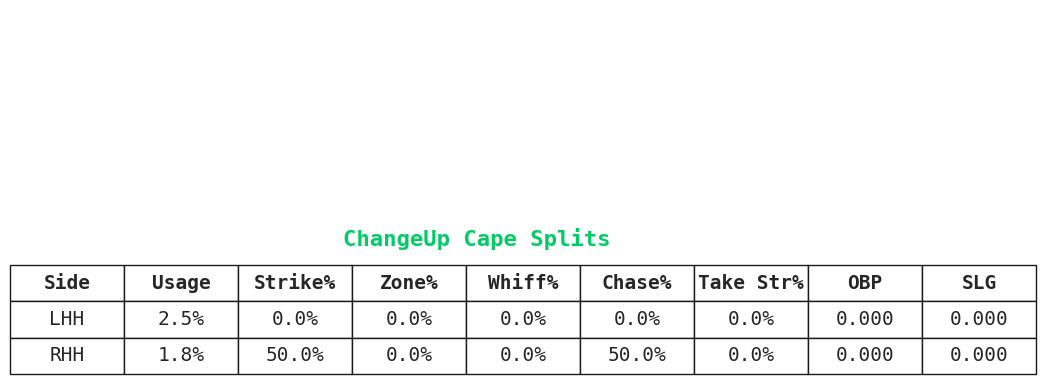

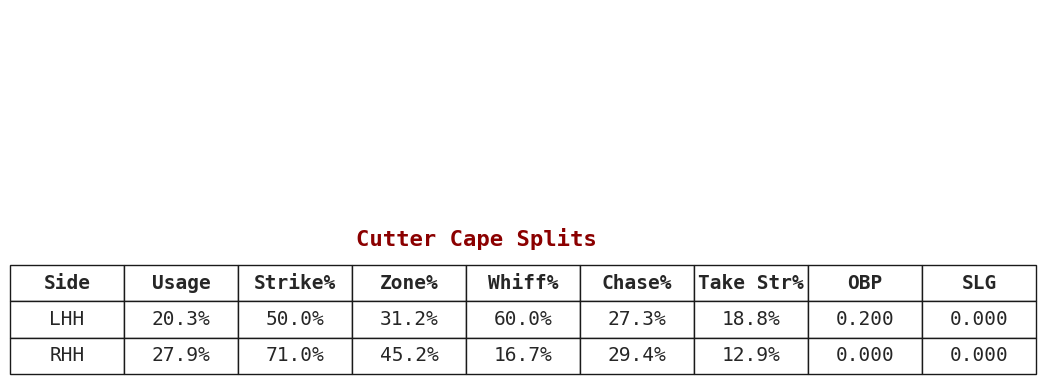

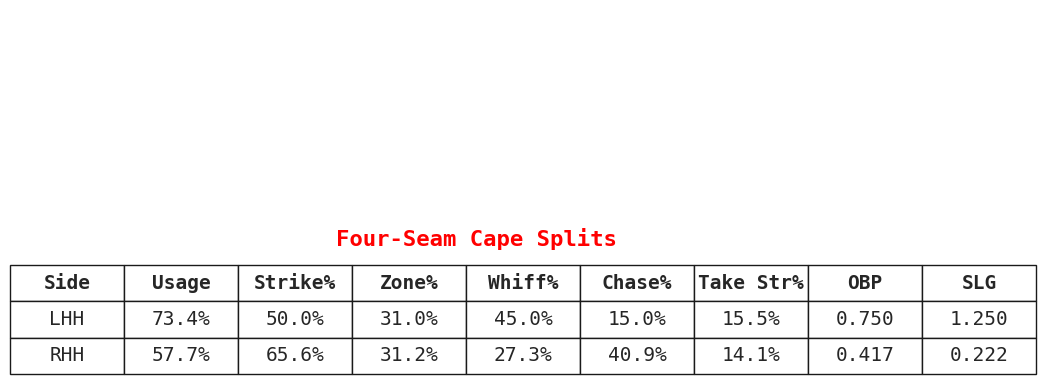

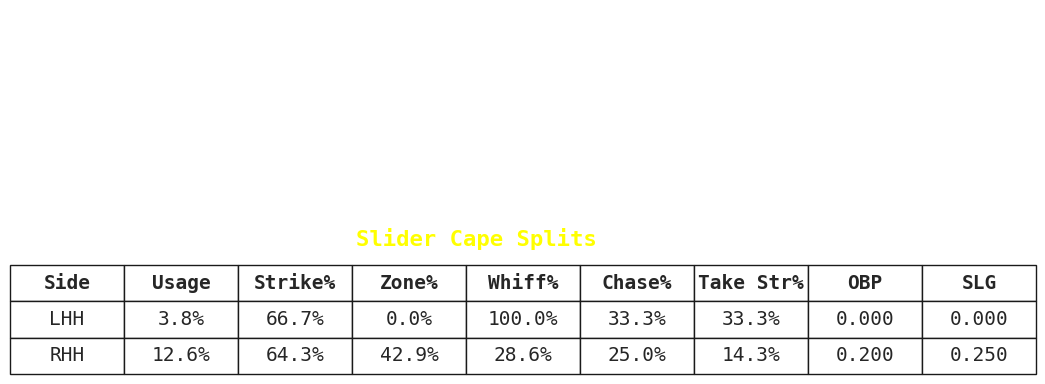

In [15]:
mpl.rcParams['font.family'] = 'DejaVu Sans Mono'

def pitch_splits(ax, data, pitch_type, table_columns, pitch_colors):
    subset = data[data['Pitch Type'] == pitch_type]
    if subset.empty:
        print(f"No data available for pitch type: {pitch_type}")
        ax.axis('off')
        return
    
    table_data = subset[table_columns].values.tolist()

    ax.axis('tight')
    ax.axis('off')
    
    table = ax.table(
        cellText=table_data,
        colLabels=table_columns,
        loc='center',
        cellLoc='center',
        bbox=[0, 0, 1.1, 0.3]
    )
    
    table.auto_set_font_size(False)
    table.set_fontsize(14)

    for (row, col), cell in table.get_celld().items():
        if row == 0:
            cell.set_text_props(weight='bold')
    
    num_cols = len(table_columns)
    width = 1 / num_cols
    for i in range(num_cols):
        for key, cell in table.get_celld().items():
            if key[1] == i:
                cell.set_width(width)
    
    title_color = pitch_colors.get(pitch_type, 'black')
    ax.set_title(f"{pitch_type} Cape Splits", fontsize=16, fontweight='bold', pad=-170, color=title_color)

table_columns = ['Side', 'Usage', 'Strike%', 'Zone%', 'Whiff%', 'Chase%', 'Take Str%', 'OBP', 'SLG']

pitch_types = final_df['Pitch Type'].unique()

for pitch in pitch_types:
    fig, ax = plt.subplots(figsize=(10.5, 4)) 
    pitch_splits(ax=ax, data=final_df, pitch_type=pitch,
                 table_columns=table_columns, pitch_colors=dict_color)
    plt.tight_layout()
    plt.show()

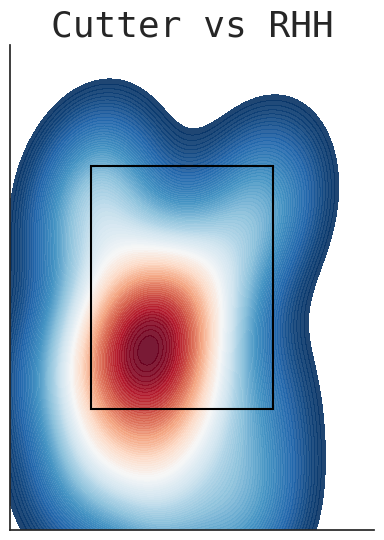

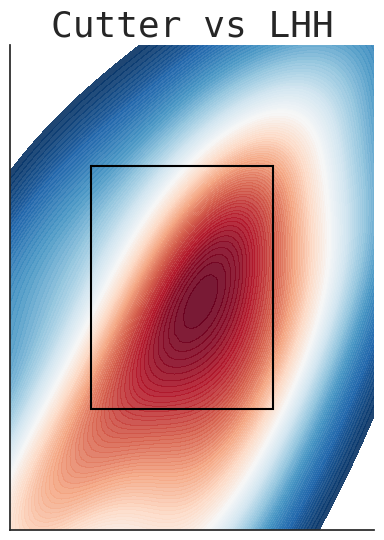

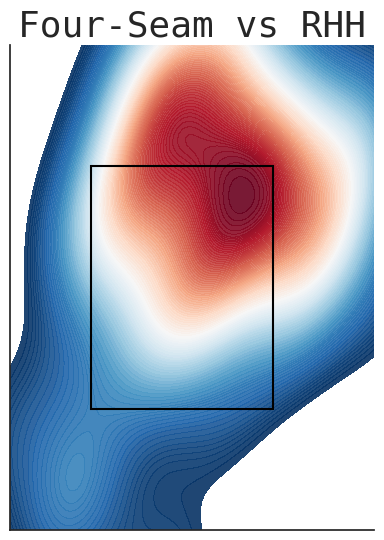

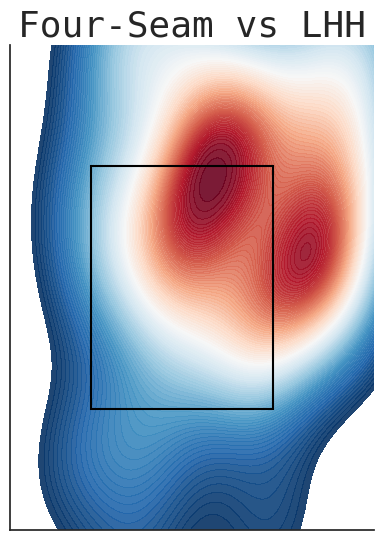

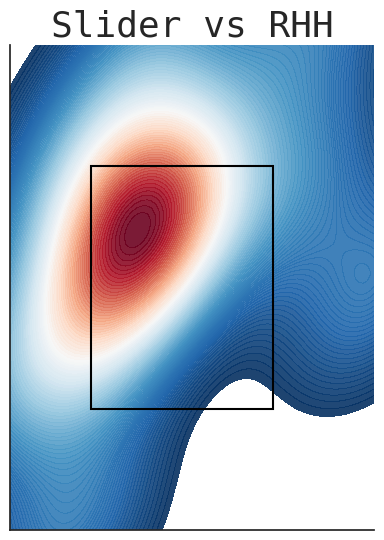

In [16]:
player_df = df[
    (df["Pitcher"].str.strip() == player_name_input.strip()) & 
    df["PlateLocSide"].notna() & 
    df["PlateLocHeight"].notna() & 
    df["TaggedPitchType"].notna() &
    df["BatterSide"].isin(["Right", "Left"])
].copy()

player_df = standardize_pitch_types(player_df)

pitch_types = player_df["TaggedPitchType"].unique()
batter_sides = ["Right", "Left"]

for pitch in pitch_types:
    for side in batter_sides:
        subset = player_df[
            (player_df["TaggedPitchType"] == pitch) & 
            (player_df["BatterSide"] == side)
        ]

        if len(subset) < 5:
            continue

        plt.figure(figsize=(4, 6))
        sns.set(style="white")

        sns.kdeplot(
            data=subset,
            x="PlateLocSide",
            y="PlateLocHeight",
            fill=True,
            thresh=0.05,
            cmap="RdBu_r",
            levels=100,
            alpha=0.9
        )

        strike_zone = Rectangle(
            (-0.83, 1.5), 1.5, 2,
            linewidth=1.5, edgecolor='black', facecolor='none'
        )
        plt.gca().add_patch(strike_zone)

        plt.xlim(-1.5, 1.5)
        plt.ylim(0.5, 4.5)
        plt.xlabel("")
        plt.ylabel("")
        plt.xticks([])
        plt.yticks([])
        plt.title(f"{pitch} vs {'RHH' if side == 'Right' else 'LHH'}", font='DejaVu Sans Mono', fontsize=26)
        plt.gca().set_aspect('equal', adjustable='box')
        sns.despine()
        plt.tight_layout()
        plt.show()